In [6]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")

In [23]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data

,co2
date,
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-07-31,315.625000
1958-08-31,314.950000
...,...
2001-08-31,369.425000
2001-09-30,367.880000
2001-10-31,368.050000


In [18]:
#X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
#y = co2_data["co2"].to_numpy()
import pandas as pd

df_ = pd.read_csv(r"data/co2_mm_mlo.csv", skiprows=56)
X = df_["decimal date"].to_numpy().reshape(-1, 1)
y = df_.average.to_numpy()

In [3]:
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor

kernel_ = 112**2 * Matern(length_scale=115, nu = 5/2) +\
          2.58**2 * Matern(length_scale=199, nu = 5/2) * ExpSineSquared(length_scale=1.36, periodicity=1, periodicity_bounds="fixed") +\
          0.575**2 * RationalQuadratic(alpha=0.672, length_scale=1.05) +\
          0.208**2 * Matern(length_scale=0.128, nu = 5/2) + WhiteKernel(noise_level=0.0382)

gpr = GaussianProcessRegressor(kernel=kernel_, optimizer=None)
y_mean = y.mean()
gpr.fit(X, y - y_mean)
gpr.kernel_

112**2 * Matern(length_scale=115, nu=2.5) + 2.58**2 * Matern(length_scale=199, nu=2.5) * ExpSineSquared(length_scale=1.36, periodicity=1) + 0.575**2 * RationalQuadratic(alpha=0.672, length_scale=1.05) + 0.208**2 * Matern(length_scale=0.128, nu=2.5) + WhiteKernel(noise_level=0.0382)

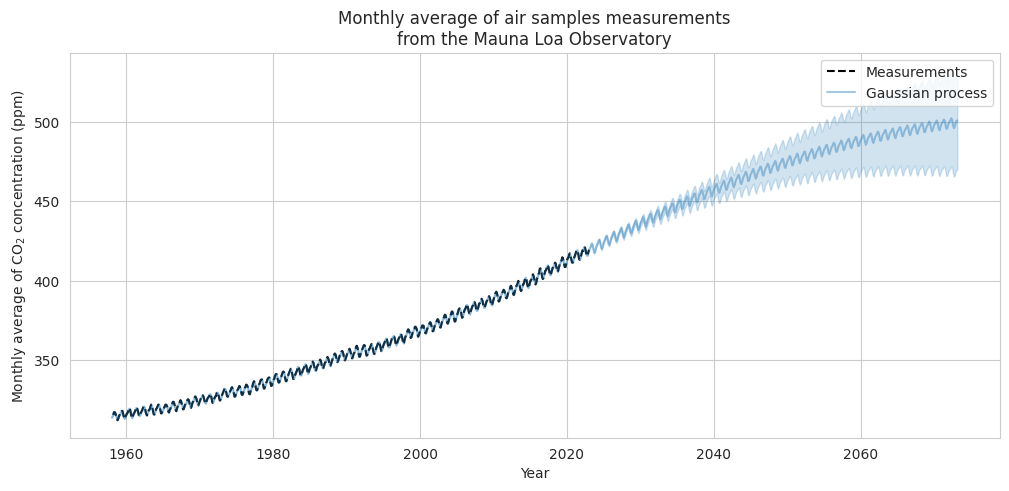

In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

today = datetime.datetime.now()
current_month = today.year + 50 + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gpr.predict(X_test, return_std=True)
mean_y_pred += y_mean
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

# BAND

In [6]:
%%capture
# Import my GP
%run ./GP.ipynb

In [36]:
X = jnp.array(X)
y = jnp.array(y)

def kernel_(k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, x_, y_):
    #k1, k2, k3, k4, k5, k6, k7, k8, k9, k10 = args
    return (MaternKernel52(k1, k2, x_, y_) +
            MaternKernel52(k3, k4, x_, y_) * ExpSineSquaredKernel(1, k5, 1, x_, y_) +
            RationalQuadraticKernel(k6, k7, k8, x_, y_) +
            MaternKernel52(k9, k10, x_, y_)) * WendlandTapering(3, 5, x_, y_)

y_mean = y.mean()
gpr = GPR(X, y - y_mean, kernel_, jnp.array([112**2, 115, 2.58**2, 199, 1.36, 0.575**2, 1.05, 0.672, 0.208**2, 0.128]), eps = 0.0382)
gpr.fit()

Starting solve...
Final solve: state.value=Array(860.78950023, dtype=float64) at [1.25443940e+04 1.14973281e+02 2.99233528e+01 1.98995383e+02
 2.88988885e+00 2.15079562e+00 1.30475097e+00 7.39616186e-01
 1.20311223e+02 2.66366745e-01]
Iter: state.iter_num=Array(44, dtype=int64, weak_type=True)


NMLL: 1669.9609777474889


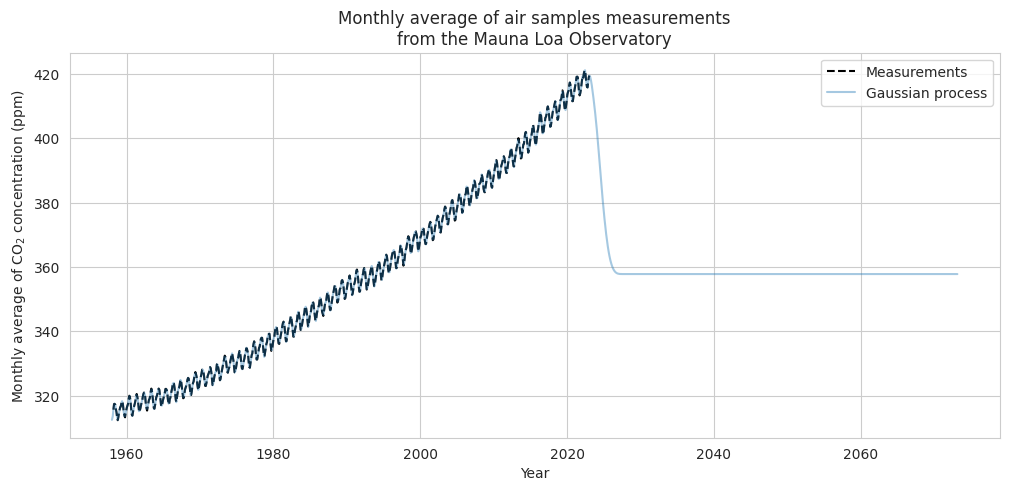

In [37]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

today = datetime.datetime.now()
current_month = today.year + 50 + today.month / 12
X_test = jnp.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred = gpr.predict(X_test, return_std=False)
mean_y_pred += y_mean
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
# plt.fill_between(
#     X_test.ravel(),
#     mean_y_pred - std_y_pred,
#     mean_y_pred + std_y_pred,
#     color="tab:blue",
#     alpha=0.2,
# )
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)